In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seasons as ps
import pandas as pd

# Generate a time series

(define what you mean by time series) Here a time series is a chronological series of data point. for now there is no importance given to the timestamp at which the event happened, only the order is important.

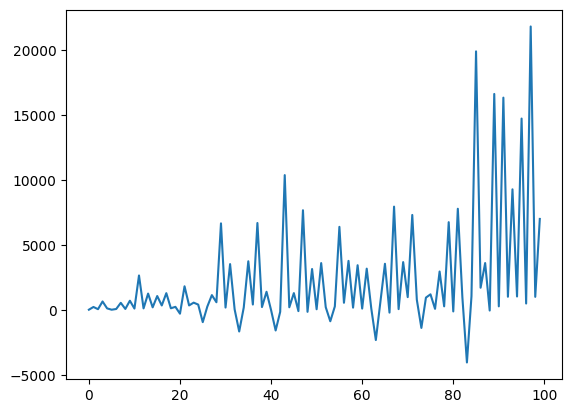

In [24]:
# Set seed
np.random.seed(0)

N = 100

y = ps.utils.generate_series(
    length=N,
    trend='linear',
    trend_coefficient=1,
    seasonality=[[1, 10], [5, 8, 9]], 
    seasonality_type='multiplicative',
    error_distribution='normal',
    error_scale=1
)

#y = 0.3*np.sin(np.arange(N)/(np.pi**0.2)) + (np.sin(np.arange(N)/(5*np.pi)))
# y = np.cumsum(np.random.randn(N))

plt.plot(y)
plt.show()

# Seasonality detection

(introduce the different methods)

## Brute force

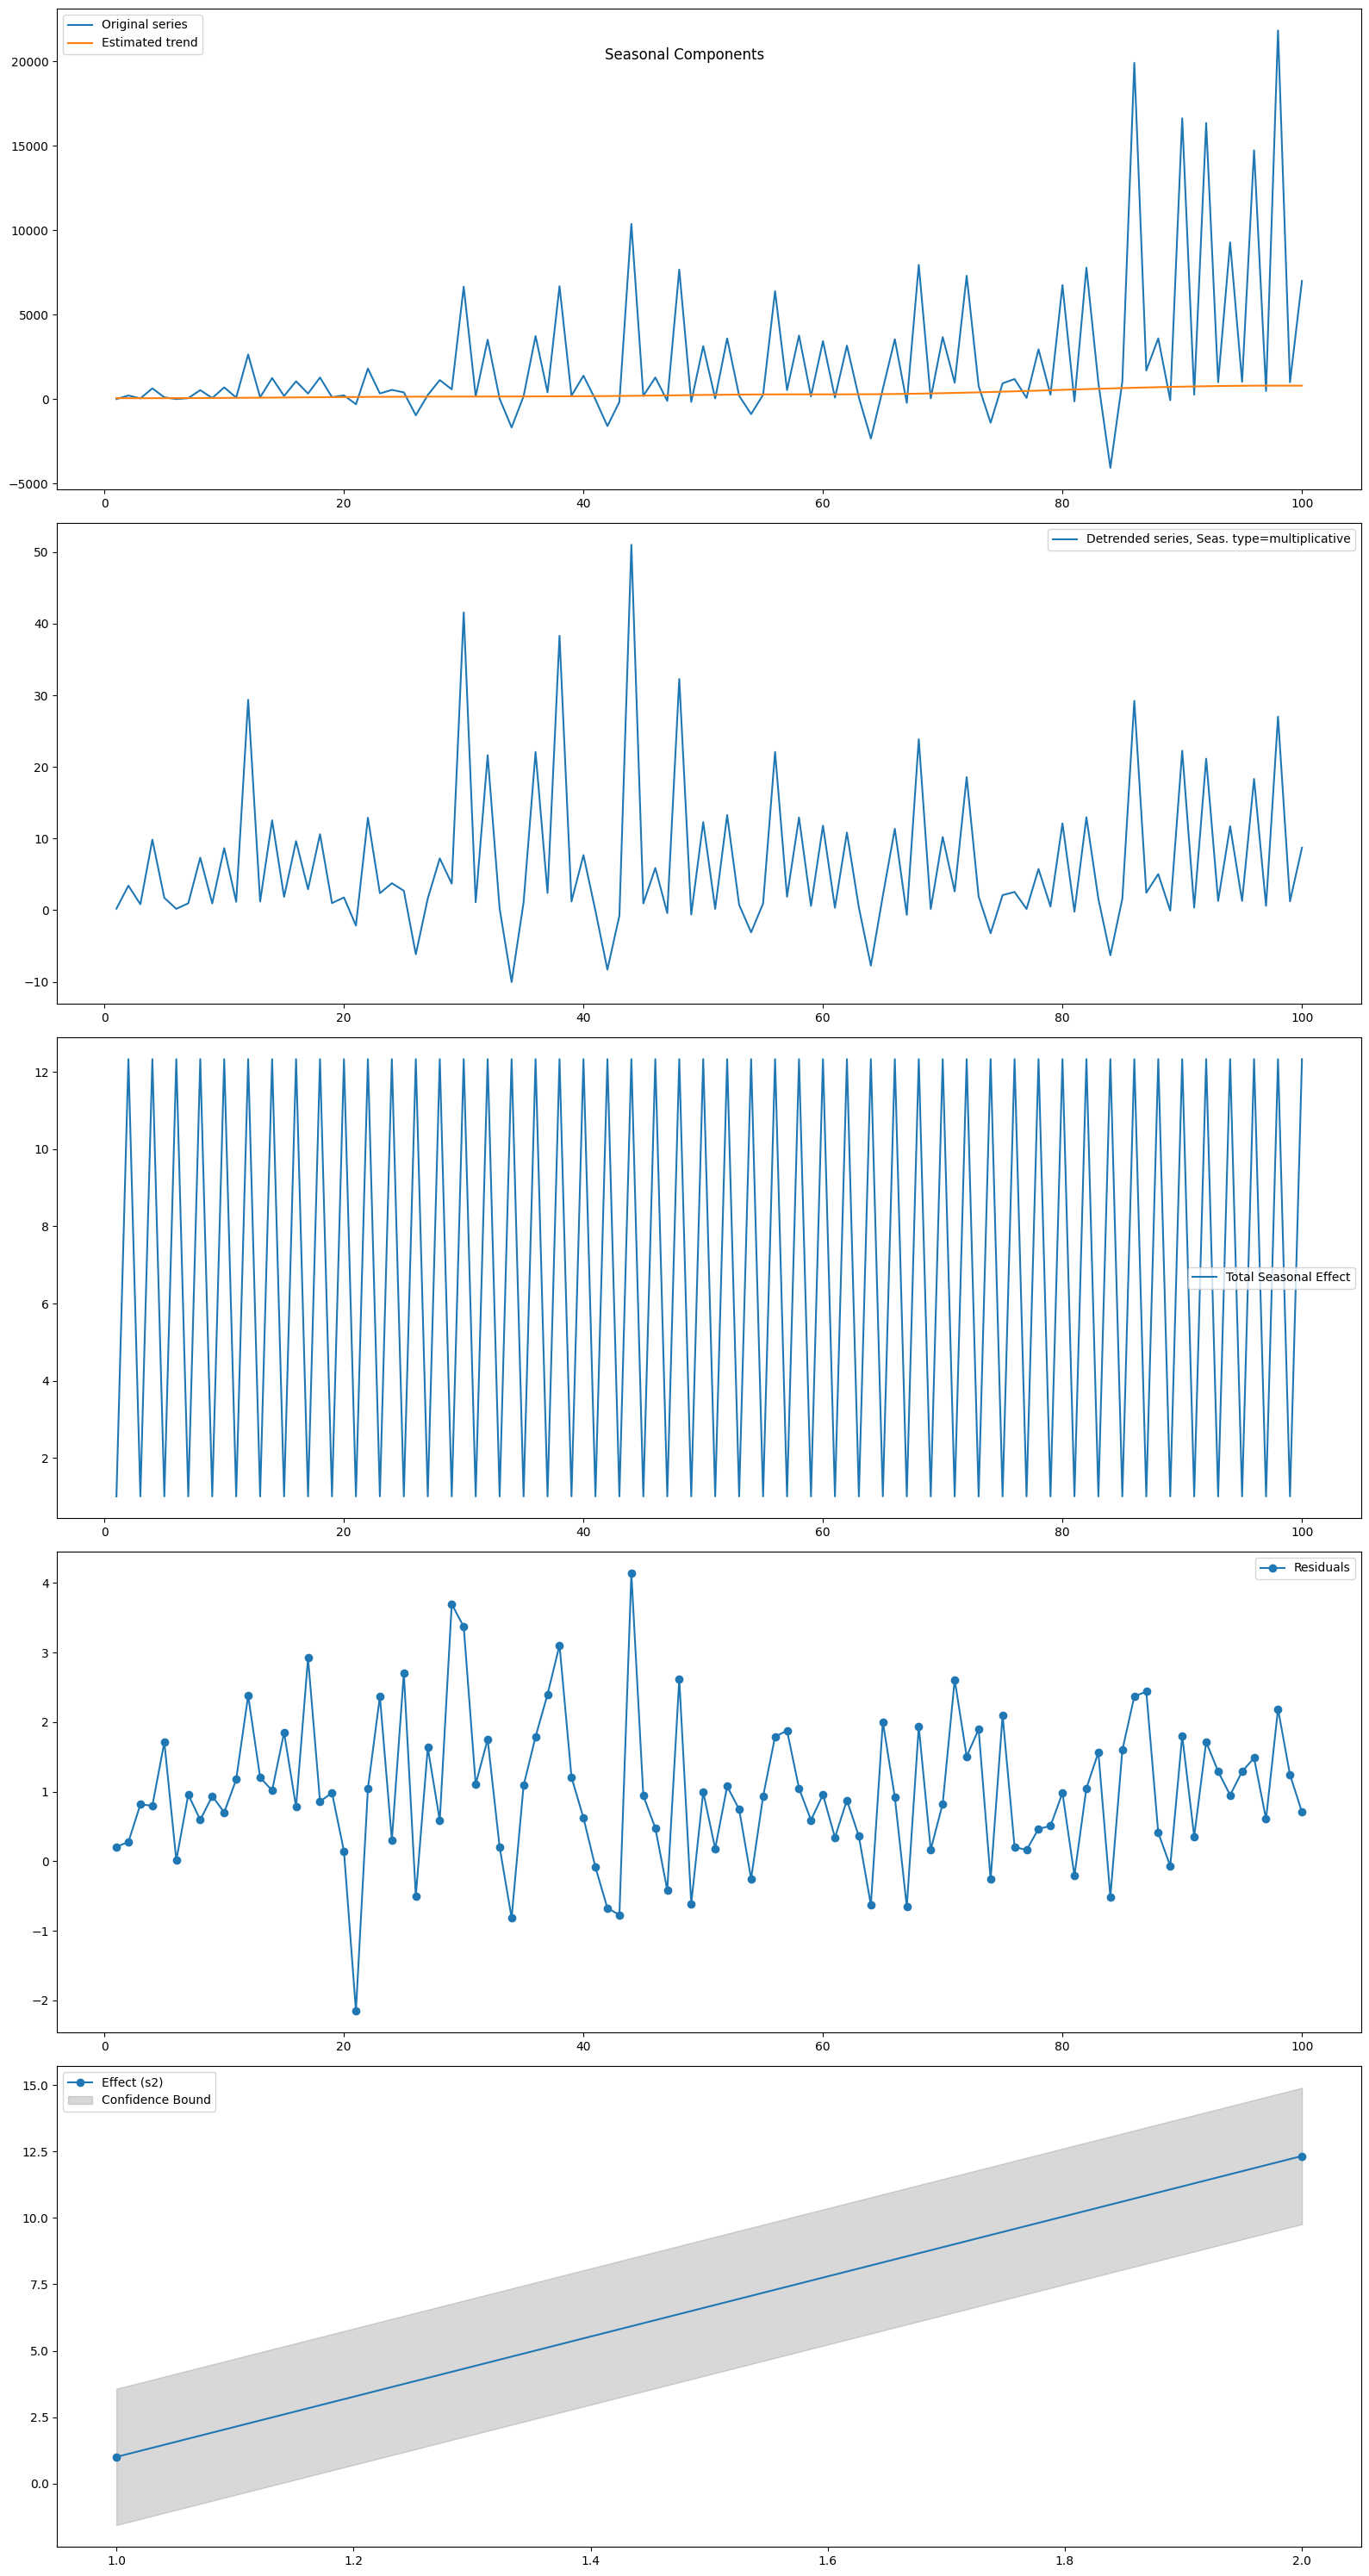

In [29]:
s, d = ps.detect.brute_force_seasonality(
    data=y,
    min_seasonality=2,
    seasonality_type='auto',
    alpha=0.05,
    display_plot=True,
    use_linear_reg=False,
    return_effects=True,
    apply_cartesian=False,
    normalize=True
)

In [30]:
d

{'s2': {'effect': [1.0, 12.334727743065473],
  'confidence_interval': [[-1.5678337129059745, 3.5678337129059745],
   [9.766894030159499, 14.902561455971448]]}}

In [20]:
d

{}

In [28]:
from sklearn.linear_model import LinearRegression


In [30]:
def _generate_design_matrix(N, seasonal_periods):
    K = len(seasonal_periods)
    num_seasonal_effects = sum(seasonal_periods)
    A = np.zeros((N, num_seasonal_effects))
    
    effect_index = 0
    for k, xk in enumerate(seasonal_periods):
        for i in range(xk):
            for t in range(N):
                if t % xk == i:
                    A[t, effect_index + i] = 1
        effect_index += xk
    
    return A

In [28]:
import pandas as pd

In [31]:
X = _generate_design_matrix(len(y), [2])

In [32]:
X_df = pd.DataFrame(X)
X_df.to_clipboard(index=False)

In [33]:
y_df = pd.DataFrame(y)
y_df.to_clipboard(index=False)

In [10]:
model = LinearRegression()
model = model.fit(X, y)

In [ ]:
import numpy as np
from scipy.stats import bartlett, f_oneway
from statsmodels.api import add_constant, OLS
from PyEMD import EMD


def _estimate_and_validate_trend(data, use_linear_reg):
    trend = _estimate_trend(data, use_linear_reg)
    if use_linear_reg == False:
        second_trend = _estimate_trend(trend, use_linear_reg)
        while _has_seasonality(trend - second_trend):
            trend = _estimate_trend(trend, use_linear_reg)
            second_trend = _estimate_trend(trend, use_linear_reg)
    return trend


def _estimate_trend(data, use_linear_reg):
    emd = EMD()
    emd_results = emd.emd(S=data)
    if (len(emd_results) == 1) or use_linear_reg:
        X = np.arange(len(data))
        X = add_constant(X)
        model = OLS(data, X)
        fitted = model.fit()
        trend = fitted.fittedvalues
    else:
        max_spline = emd.extract_max_min_spline(T=np.arange(len(data)), S=data)[0]
        min_spline = emd.extract_max_min_spline(T=np.arange(len(data)), S=data)[1]
        trend = (max_spline + min_spline) / 2
    return trend

def _has_seasonality(data):
    max_seasonality = int(len(data) // 3)
    best_seasonality = []
    for seasonality in range(2, max_seasonality + 1):
        if any(seasonality % seas == 0 for seas in best_seasonality):
            continue
        reshaped_data = data[:len(data) // seasonality * seasonality].reshape(-1, seasonality)
        _, p_value = f_oneway(*reshaped_data.T)
        if p_value < 0.05:
            best_seasonality.append(seasonality)
    return bool(best_seasonality)

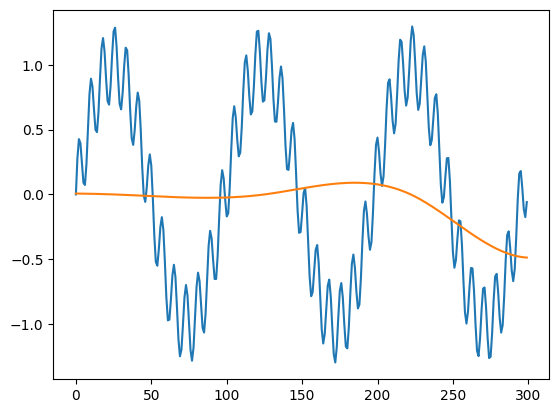

In [12]:
plt.plot(y)
plt.plot(_estimate_and_validate_trend(y, False))

In [13]:
use_linear_reg = False

In [18]:
t1 = _estimate_trend(y, use_linear_reg)
t2 = _estimate_trend(t1, use_linear_reg)

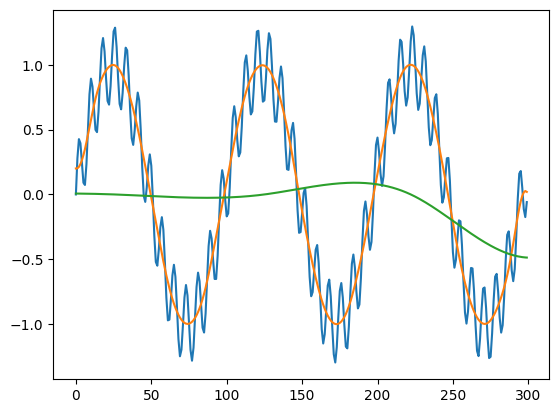

In [19]:
plt.plot(y)
plt.plot(t1)
plt.plot(t2)

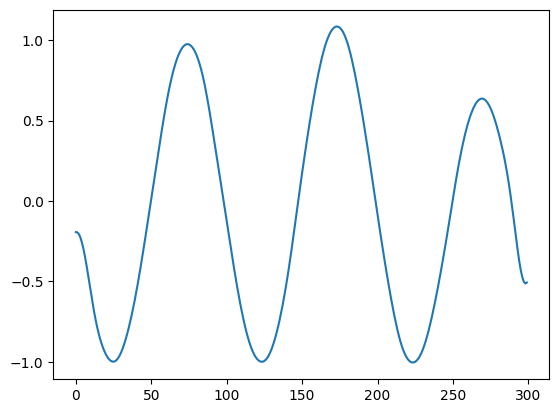

In [20]:
plt.plot(t2 - t1)